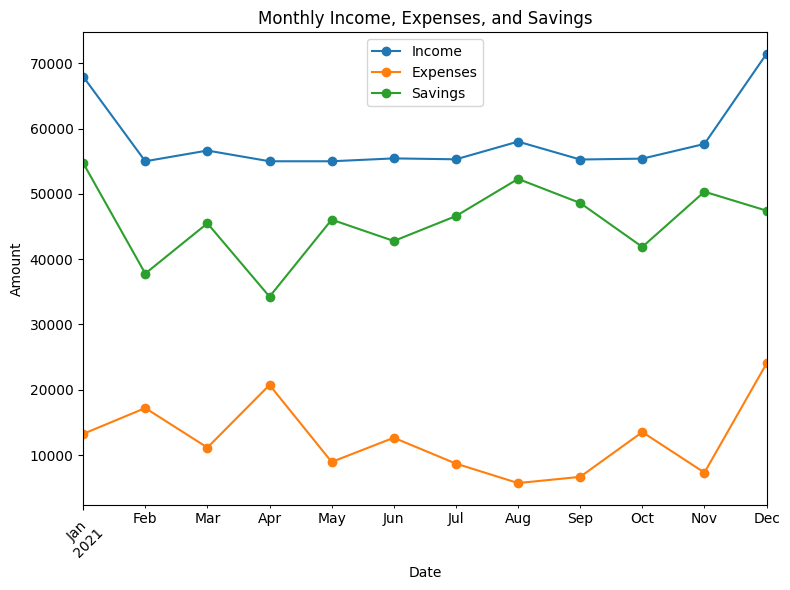

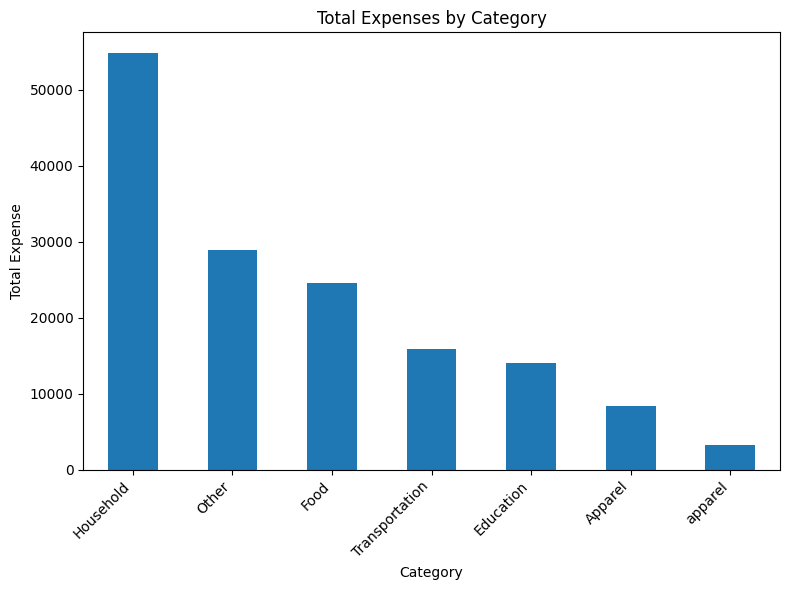

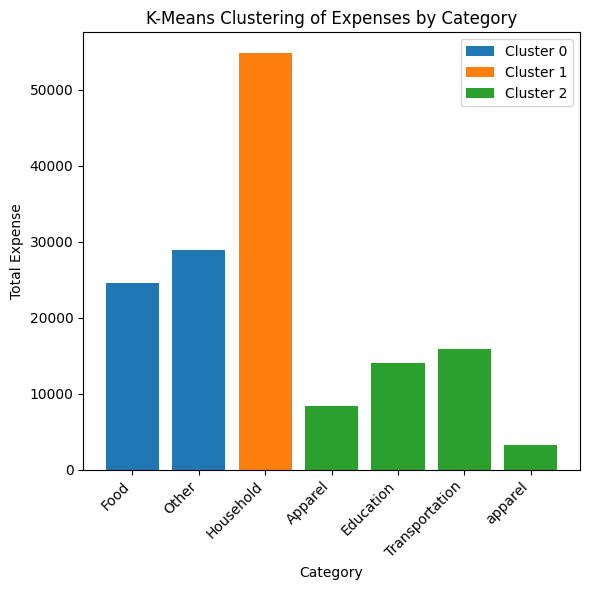

K-Means Clustering Results:
         Category  Debit/Credit  Category_Encoded  Debit/Credit_Scaled  \
0         Apparel       8396.00                 0            -0.819340   
1       Education      14000.00                 1            -0.466456   
2            Food      24607.76                 2             0.201513   
3       Household      54810.00                 3             2.103344   
4           Other      28887.00                 4             0.470976   
5  Transportation      15873.80                 5            -0.348463   
6         apparel       3278.72                 6            -1.141574   

   Cluster  
0        2  
1        2  
2        0  
3        1  
4        0  
5        2  
6        2  


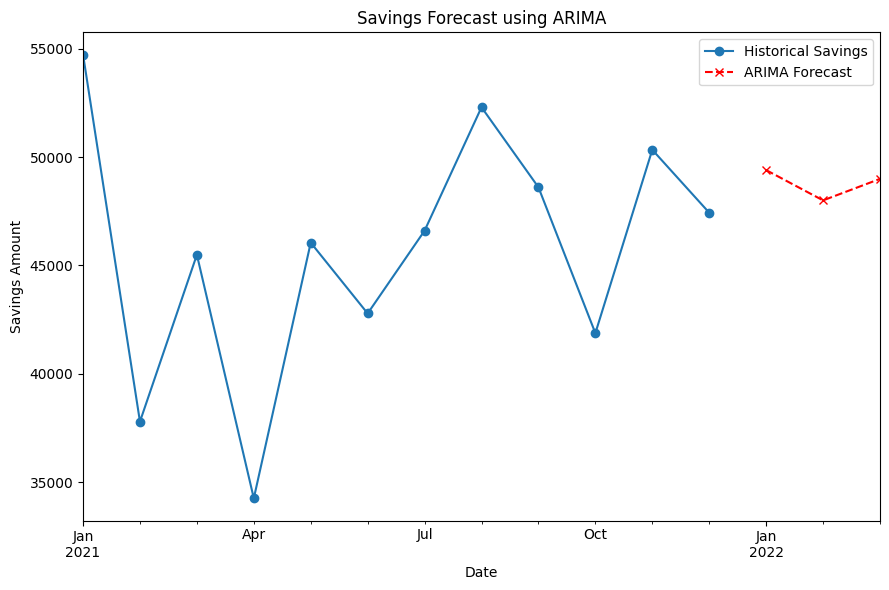

ARIMA Forecast: 2022-01-01    49399.957702
2022-02-01    48003.527080
2022-03-01    48995.545619
Freq: MS, Name: predicted_mean, dtype: float64
Mean Squared Error: 75556807.67693807
Root Mean Squared Error: 8692.341898299794
R-squared Score: 0.3720343848765696
Future Savings Predictions:
Month 1: 51897.4253968254
Month 2: 52992.89264550265
Month 3: 54088.3598941799


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
from typing import Dict, List, Any

class PersonalFinanceAnalyzer:
    def __init__(self, file_path: str):
        self.df = pd.read_csv(file_path)

        # Convert Date column to datetime
        self.df['Date'] = pd.to_datetime(self.df['Date / Time'], format='%d %B %Y')

        # Add Month and Year columns for easier grouping
        self.df['Month'] = self.df['Date'].dt.to_period('M')

        # Separate Income and Expenses
        self.income_df = self.df[self.df['Income/Expense'] == 'Income']
        self.expense_df = self.df[self.df['Income/Expense'] == 'Expense']

    def calculate_monthly_finances(self) -> pd.DataFrame:
        """
        Calculate monthly income, expenses, and savings
        """
        # Group by month and calculate totals using Period column
        monthly_income = self.income_df.groupby('Month')['Debit/Credit'].sum().reset_index()
        monthly_expense = self.expense_df.groupby('Month')['Debit/Credit'].sum().reset_index()

        # Convert Period to datetime for consistency
        monthly_income['Date'] = monthly_income['Month'].dt.to_timestamp()
        monthly_expense['Date'] = monthly_expense['Month'].dt.to_timestamp()

        # Calculate monthly savings
        monthly_savings = monthly_income.copy()
        monthly_savings['Savings'] = monthly_income['Debit/Credit'] - monthly_expense['Debit/Credit']
        monthly_savings = monthly_savings[['Date', 'Debit/Credit', 'Savings']]

        return monthly_savings

    def visualize_monthly_trends(self, monthly_savings: pd.DataFrame):
        """
        Create visualizations of monthly financial trends
        """
        # Prepare data for plotting
        income = monthly_savings.set_index('Date')['Debit/Credit']
        expenses = (self.expense_df.groupby('Month')['Debit/Credit']
                    .sum()
                    .reset_index()
                    .set_index('Month')
                    .to_timestamp()['Debit/Credit'])
        savings = monthly_savings.set_index('Date')['Savings']

        # Monthly Trends Plot
        plt.figure(figsize=(8, 6))
        income.plot(label='Income', marker='o')
        expenses.plot(label='Expenses', marker='o')
        savings.plot(label='Savings', marker='o')

        plt.title('Monthly Income, Expenses, and Savings')
        plt.xlabel('Date')
        plt.ylabel('Amount')
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        # Expense Categories Plot
        category_expenses = self.expense_df.groupby('Category')['Debit/Credit'].sum().sort_values(ascending=False)
        plt.figure(figsize=(8, 6))
        category_expenses.plot(kind='bar')
        plt.title('Total Expenses by Category')
        plt.xlabel('Category')
        plt.ylabel('Total Expense')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

    def forecast_savings(self, monthly_savings: pd.DataFrame) -> Dict[str, Any]:
        """
        Forecast savings using ARIMA and Linear Regression
        """
        # Prepare data for ARIMA with explicit frequency
        savings_series = monthly_savings.set_index('Date')['Savings']
        savings_series.index.freq = 'MS'  # Set monthly start frequency

        # ARIMA Forecasting
        try:
          arima_model = ARIMA(savings_series, order=(1,1,1))
          arima_results = arima_model.fit()
          arima_forecast = arima_results.forecast(steps=3)

        except Exception as e:
            print(f"ARIMA Forecasting failed: {e}")
            arima_forecast = [np.mean(savings_series)] * 3


        # Prepare data for Linear Regression
        X = monthly_savings.index.astype(int).values.reshape(-1, 1)
        y = monthly_savings['Savings'].values

        # Split and scale data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Linear Regression
        lr_model = LinearRegression()
        lr_model.fit(X_train_scaled, y_train)

        # Evaluate model
        y_pred = lr_model.predict(X_test_scaled)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        #mse = np.mean((y_test - y_pred)**2)
        r2 = lr_model.score(X_train_scaled, y_train)

        # Future predictions
        future_dates = np.array(range(len(X), len(X) + 3)).reshape(-1, 1)
        future_dates_scaled = scaler.transform(future_dates)
        future_predictions = lr_model.predict(future_dates_scaled)

        return {
            'savings_series':savings_series,
            'arima_results': arima_results,
            'arima_forecast': arima_forecast,
            'mse': mse,
            'rmse': rmse,
            'r2_score': r2,
            'future_predictions': future_predictions
        }

    def plot_arima_forecast(self, forecast_results: Dict[str, Any]):
        """
        Plot ARIMA forecast for savings
        """
        # Get original savings series and forecast
        savings_series = forecast_results['savings_series']
        arima_results = forecast_results['arima_results']
        arima_forecast = forecast_results['arima_forecast']

        # Create forecast dates
        last_date = savings_series.index[-1]
        forecast_dates = pd.date_range(start=last_date, periods=4, freq='MS')[1:]

        # Plot
        plt.figure(figsize=(9, 6))

        # Original data
        savings_series.plot(label='Historical Savings', marker='o')

        # Forecast
        forecast_series = pd.Series(arima_forecast, index=forecast_dates)
        forecast_series.plot(label='ARIMA Forecast', color='red', linestyle='--', marker='x')
        '''
        # Confidence intervals
        forecast = arima_results.get_prediction(start=last_date, end=forecast_dates[-1])
        conf_int = forecast.conf_int()
        plt.fill_between(forecast_dates,
                         conf_int.iloc[:, 0],
                         conf_int.iloc[:, 1],
                         color='pink', alpha=0.3,
                         label='95% Confidence Interval')
        '''
        plt.title('Savings Forecast using ARIMA')
        plt.xlabel('Date')
        plt.ylabel('Savings Amount')
        plt.legend()
        plt.tight_layout()
        plt.show()

    def perform_kmeans_clustering(self, n_clusters: int = 3):
      """
      Perform K-Means clustering on expense data to identify spending patterns.
      """
      # Prepare data for clustering
      clustering_data = self.expense_df[['Category', 'Debit/Credit']]
      clustering_data = clustering_data.groupby('Category').sum().reset_index()

      # Encode categories (if necessary)
      clustering_data['Category_Encoded'] = clustering_data['Category'].astype('category').cat.codes

      # Standardize the 'Debit/Credit' data
      scaler = StandardScaler()
      clustering_data['Debit/Credit_Scaled'] = scaler.fit_transform(clustering_data[['Debit/Credit']])

      # Apply K-Means clustering
      kmeans = KMeans(n_clusters=n_clusters, random_state=42)
      clustering_data['Cluster'] = kmeans.fit_predict(clustering_data[['Debit/Credit_Scaled']])

      # Visualize Clusters
      plt.figure(figsize=(6, 6))
      for cluster in range(n_clusters):
          cluster_data = clustering_data[clustering_data['Cluster'] == cluster]
          plt.bar(cluster_data['Category'], cluster_data['Debit/Credit'], label=f'Cluster {cluster}')

      plt.title('K-Means Clustering of Expenses by Category')
      plt.xlabel('Category')
      plt.ylabel('Total Expense')
      plt.xticks(rotation=45, ha='right')
      plt.legend()
      plt.tight_layout()
      plt.show()

      return clustering_data



    def run_full_analysis(self):
        """
        Run complete financial analysis
        """
        # Calculate monthly finances
        monthly_savings = self.calculate_monthly_finances()

        # Create visualizations
        self.visualize_monthly_trends(monthly_savings)

        # Forecast savings
        forecast_results = self.forecast_savings(monthly_savings)

        # Perform K-Means clustering
        clustering_results = self.perform_kmeans_clustering()
        print("K-Means Clustering Results:")
        print(clustering_results)

        # Plot ARIMA forecast
        self.plot_arima_forecast(forecast_results)


        # Print results
        print("ARIMA Forecast:", forecast_results['arima_forecast'])
        print(f"Mean Squared Error: {forecast_results['mse']}")
        print(f"Root Mean Squared Error: {forecast_results['rmse']}")
        print(f"R-squared Score: {forecast_results['r2_score']}")
        print("Future Savings Predictions:")
        for i, prediction in enumerate(forecast_results['future_predictions'], 1):
            print(f"Month {i}: {prediction}")

        return forecast_results



def main():
    # Create analyzer instance
    analyzer = PersonalFinanceAnalyzer('/content/personal finance data.csv')

    # Run full analysis
    analyzer.run_full_analysis()

if __name__ == "__main__":
    main()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
